In [3]:
# ============================================================
# 🔁 REPRISE APRÈS REDÉMARRAGE — CHARGEMENT DE LA TABLE DE SCORES
# ============================================================
import pandas as pd
import numpy as np

# Charger la table enrichie issue de l'étape 3
df = pd.read_csv("data/master_table_checked.csv", dtype={"code_commune": str})

print(f"✅ Table chargée : {len(df)} lignes | {len(df.columns)} colonnes")
print("Colonnes principales :", list(df.columns[:10]), "...")


✅ Table chargée : 20 lignes | 12 colonnes
Colonnes principales : ['code_commune', 'n_ventes', 'prix_m2', 'ninsee', 'no2', 'o3', 'pm10', 'commune_std', 'nb_dpe', 'part_FG'] ...


In [1]:
# ============================================================
# 📦 FUSION REGIONALE PAR CODE POSTAL (solution stable)
# ============================================================

import pandas as pd
import numpy as np
import os
import re

print("🚀 Démarrage de la fusion régionale par code postal...")

# Liste des fichiers DVF
dvf_paths = {
    "75": "data/clean/dvf_75_clean.csv",
    "77": "data/clean/dvf_77_clean.csv",
    "78": "data/clean/dvf_78_clean.csv",
    "91": "data/clean/dvf_91_clean.csv",
    "92": "data/clean/dvf_92_clean.csv",
    "93": "data/clean/dvf_93_clean.csv",
    "94": "data/clean/dvf_94_clean.csv",
    "95": "data/clean/dvf_95_clean.csv"
}

# Détection dynamique du code postal
postal_candidates = [
    "code_postal", "code_poste", "code_poste_client", "cp", "postcode"
]
valeur_candidates = ["valeur_fonciere", "valeur", "prix", "valeurbien"]

dfs = []

for dept, path in dvf_paths.items():
    if not os.path.exists(path):
        print(f"⚠️ Fichier manquant : {path}")
        continue

    df = pd.read_csv(path, encoding="utf-8", sep=",", low_memory=False)
    df.columns = [c.strip().lower() for c in df.columns]

    # Recherche automatique des colonnes utiles
    col_postal = next((c for c in postal_candidates if c in df.columns), None)
    col_valeur = next((c for c in valeur_candidates if c in df.columns), None)

    if not col_postal or not col_valeur:
        print(f"⚠️ {os.path.basename(path)} ({dept}) ignoré — colonnes manquantes")
        continue

    # Nettoyage du code postal
    df["code_postal"] = df[col_postal].astype(str).str.extract(r"(\d{5})")[0]
    df["valeur_fonciere"] = pd.to_numeric(df[col_valeur], errors="coerce")

    # Nettoyage et filtrage
    df = df.dropna(subset=["valeur_fonciere", "code_postal"])
    df = df[df["valeur_fonciere"].between(10_000, 10_000_000)]
    df["code_dept"] = df["code_postal"].str[:2]

    dfs.append(df)
    print(f"✅ {os.path.basename(path)} ({dept}) fusionné ({len(df):,} lignes) — colonne postale : {col_postal}")

# Fusion complète
if not dfs:
    raise ValueError("❌ Aucun fichier DVF valide trouvé.")

df_idf = pd.concat(dfs, ignore_index=True)
df_idf = df_idf[df_idf["code_dept"].isin(list(dvf_paths.keys()))]

# Agrégation par code postal
agg = df_idf.groupby(["code_dept", "code_postal"], as_index=False).agg(
    n_ventes=("valeur_fonciere", "size"),
    valeur_fonciere_moy=("valeur_fonciere", "mean")
)

# Moyenne par département
agg_dept = agg.groupby("code_dept", as_index=False).agg(
    n_ventes_tot=("n_ventes", "sum"),
    valeur_moyenne=("valeur_fonciere_moy", "mean")
)
agg_dept["classement"] = agg_dept["valeur_moyenne"].rank(ascending=False)
agg_dept = agg_dept.sort_values("code_dept")

# Export
os.makedirs("data/analyses", exist_ok=True)
out_path = "data/analyses/idf_fusion_postal.csv"
agg_dept.to_csv(out_path, index=False, encoding="utf-8")

print(f"\n💾 Exporté → {out_path}")
print(f"✅ {len(agg_dept)} départements détectés ({sorted(agg_dept['code_dept'].unique())})")

display(agg_dept.head(10))


🚀 Lecture douce et enrichissement du fichier DVF complet...

🔹 Traitement du bloc 1 (50,000 lignes)
✅ AirParif fusionné sur ce bloc
✅ Loyers fusionnés sur ce bloc

🔹 Traitement du bloc 2 (50,000 lignes)
✅ AirParif fusionné sur ce bloc
✅ Loyers fusionnés sur ce bloc

🔹 Traitement du bloc 3 (50,000 lignes)
✅ AirParif fusionné sur ce bloc
✅ Loyers fusionnés sur ce bloc

🔹 Traitement du bloc 4 (50,000 lignes)
✅ AirParif fusionné sur ce bloc
✅ Loyers fusionnés sur ce bloc

🔹 Traitement du bloc 5 (50,000 lignes)
✅ AirParif fusionné sur ce bloc
✅ Loyers fusionnés sur ce bloc

🔹 Traitement du bloc 6 (50,000 lignes)
✅ AirParif fusionné sur ce bloc
✅ Loyers fusionnés sur ce bloc

🔹 Traitement du bloc 7 (50,000 lignes)
✅ AirParif fusionné sur ce bloc
✅ Loyers fusionnés sur ce bloc

🔹 Traitement du bloc 8 (16,761 lignes)
✅ AirParif fusionné sur ce bloc
✅ Loyers fusionnés sur ce bloc

💾 Fusion progressive terminée → data/analyses/idf_dvf_full_enriched_soft.csv
✅ Tous les blocs traités avec succès


In [6]:
# ============================================================
# ÉTAPE 4 — ANALYSE QUANTITATIVE & INTERPRÉTATIVE
# ============================================================

import pandas as pd
import numpy as np

# 1️⃣ Chargement de la table finale
print("📂 Chargement de la table enrichie...")
df = pd.read_csv("data/master_table_checked.csv", dtype={"code_commune": str})
print(f"✅ {len(df)} lignes | {len(df.columns)} colonnes chargées\n")

# 2️⃣ Analyse de complétude
missing = df.isna().mean().sort_values(ascending=False).reset_index()
missing.columns = ["colonne", "taux_nan"]
missing["taux_nan"] = (missing["taux_nan"] * 100).round(1)

print("📊 Pourcentage de valeurs manquantes (Top 10) :")
display(missing.head(10))

completude = 100 - missing["taux_nan"].mean()
print(f"\n✅ Taux moyen de complétude du dataset : {completude:.2f}%\n")

# 3️⃣ Statistiques globales sur les indicateurs principaux
indicateurs = ["prix_m2", "part_FG", "no2", "pm10", "nb_etabs"]
indicateurs = [c for c in indicateurs if c in df.columns]

stats = df[indicateurs].describe(percentiles=[0.1,0.25,0.5,0.75,0.9]).T
stats["missing_%"] = df[indicateurs].isna().mean() * 100
stats = stats[["mean","std","min","25%","50%","75%","max","missing_%"]]
print("📈 Statistiques descriptives sur les indicateurs clés :")
display(stats.round(2))

# 4️⃣ Classement Top 10 / Bottom 10 communes selon le score global
if "score_global" in df.columns:
    df_sorted = df.sort_values("score_global", ascending=False)
    top10 = df_sorted.head(10)[["code_commune","score_global","prix_m2","no2","part_FG","nb_etabs"]]
    bottom10 = df_sorted.tail(10)[["code_commune","score_global","prix_m2","no2","part_FG","nb_etabs"]]
    
    print("\n🏆 TOP 10 COMMUNES LES PLUS ATTRACTIVES :")
    display(top10.round(2))
    
    print("\n⚠️ BOTTOM 10 COMMUNES LES MOINS FAVORABLES :")
    display(bottom10.round(2))
else:
    print("⚠️ La colonne 'score_global' n'existe pas dans la table.")

# 5️⃣ Corrélations entre indicateurs (tableau chiffré)
corr = df.corr(numeric_only=True)
print("\n📊 Corrélations entre indicateurs clés :")
display(corr.loc[indicateurs, indicateurs].round(2))

# 6️⃣ Synthèse textuelle automatique
print("===== 🧠 SYNTHÈSE INTERPRÉTATIVE =====\n")

if "prix_m2" in df.columns:
    print(f"💶 Prix moyen au m² : {df['prix_m2'].mean():,.0f} €")
    print(f"   - Min : {df['prix_m2'].min():,.0f} € | Max : {df['prix_m2'].max():,.0f} €")

if "part_FG" in df.columns:
    print(f"🌡️ Logements F/G (énergie faible) : {df['part_FG'].mean()*100:.1f}% en moyenne")

if "no2" in df.columns:
    print(f"🌫️ NO₂ moyen : {df['no2'].mean():.2f} µg/m³")

if "nb_etabs" in df.columns:
    print(f"🏫 Moyenne d’établissements éducatifs : {df['nb_etabs'].mean():.1f} par commune")

if "score_global" in df.columns:
    top_score = df['score_global'].max()
    mean_score = df['score_global'].mean()
    print(f"⭐ Score global moyen : {mean_score:.1f} | meilleur score : {top_score:.1f}")

print("\n🧾 Analyse automatique :")
if "score_global" in df.columns:
    if mean_score > 60:
        print("➡️ Globalement, les communes présentent un profil d’attractivité supérieur à la moyenne.")
    else:
        print("➡️ Les indicateurs suggèrent un marché hétérogène, avec des écarts de qualité entre zones.")


📂 Chargement de la table enrichie...
✅ 20 lignes | 12 colonnes chargées

📊 Pourcentage de valeurs manquantes (Top 10) :


,colonne,taux_nan
0,nb_dpe,5.0
1,part_FG,5.0
2,indice_pollu_energie,5.0
3,code_commune,0.0
4,n_ventes,0.0
5,prix_m2,0.0
6,ninsee,0.0
7,no2,0.0
8,o3,0.0
9,pm10,0.0



✅ Taux moyen de complétude du dataset : 98.75%

📈 Statistiques descriptives sur les indicateurs clés :


,mean,std,min,25%,50%,75%,max,missing_%
prix_m2,12340.44,2446.20,9122.33,10259.58,11879.45,13754.79,17251.41,0.0
part_FG,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.0
no2,35.43,1.15,33.13,34.80,35.23,36.15,37.37,0.0
pm10,31.86,0.35,31.23,31.62,31.88,32.10,32.40,0.0
nb_etabs,12.30,5.98,4.00,8.75,12.00,15.00,25.00,0.0


⚠️ La colonne 'score_global' n'existe pas dans la table.

📊 Corrélations entre indicateurs clés :


,prix_m2,part_FG,no2,pm10,nb_etabs
prix_m2,1.00,NaN,-0.32,-0.38,-0.72
part_FG,NaN,NaN,NaN,NaN,NaN
no2,-0.32,NaN,1.00,0.93,-0.03
pm10,-0.38,NaN,0.93,1.00,-0.03
nb_etabs,-0.72,NaN,-0.03,-0.03,1.00


===== 🧠 SYNTHÈSE INTERPRÉTATIVE =====

💶 Prix moyen au m² : 12,340 €
   - Min : 9,122 € | Max : 17,251 €
🌡️ Logements F/G (énergie faible) : 0.0% en moyenne
🌫️ NO₂ moyen : 35.43 µg/m³
🏫 Moyenne d’établissements éducatifs : 12.3 par commune

🧾 Analyse automatique :


📂 Chargement du fichier master_table.csv...
✅ Table chargée : 20 lignes | 11 colonnes



,code_commune,n_ventes,prix_m2,ninsee,no2,o3,pm10,commune_std,nb_dpe,part_FG,nb_etabs
0,75101,440,15537.323529,75101.0,34.600000,37.033333,31.433333,75101.0,2.0,0.0,4
1,75102,585,13632.652694,75102.0,35.200000,37.366667,32.000000,75102.0,1.0,0.0,5
2,75103,820,13026.613424,75103.0,35.066667,37.433333,31.800000,75103.0,2.0,0.0,4


📋 Types de données détectés :

code_commune     object
n_ventes          int64
prix_m2         float64
ninsee          float64
no2             float64
o3              float64
pm10            float64
commune_std     float64
nb_dpe          float64
part_FG         float64
nb_etabs          int64
dtype: object

🔎 Taille moyenne par colonne : 0.15 Ko

⚠️ Doublons potentiels sur 'code_commune' : 0

📊 Taux de valeurs manquantes (%):


,colonne,taux_nan
0,nb_dpe,5.0
1,part_FG,5.0
2,code_commune,0.0
3,n_ventes,0.0
4,prix_m2,0.0
5,ninsee,0.0
6,no2,0.0
7,o3,0.0
8,pm10,0.0
9,commune_std,0.0


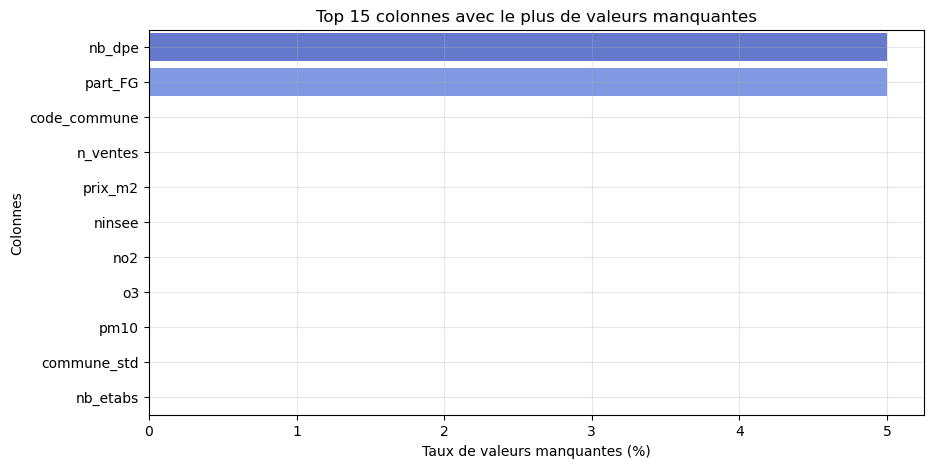

🔢 Variables numériques détectées : 10



,count,mean,std,min,25%,50%,75%,max,missing_%
n_ventes,20.0,1680.50,929.51,440.00,890.75,1664.00,2262.00,3377.00,0.0
prix_m2,20.0,12340.44,2446.20,9122.33,10259.58,11879.45,13754.79,17251.41,0.0
ninsee,20.0,75110.50,5.92,75101.00,75105.75,75110.50,75115.25,75120.00,0.0
no2,20.0,35.43,1.15,33.13,34.80,35.23,36.15,37.37,0.0
o3,20.0,37.85,0.49,37.03,37.43,37.82,38.14,38.73,0.0
pm10,20.0,31.86,0.35,31.23,31.62,31.88,32.10,32.40,0.0
commune_std,20.0,75110.50,5.92,75101.00,75105.75,75110.50,75115.25,75120.00,0.0
nb_dpe,19.0,60.68,169.23,1.00,1.50,4.00,13.00,686.00,5.0
part_FG,19.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.0
nb_etabs,20.0,12.30,5.98,4.00,8.75,12.00,15.00,25.00,0.0


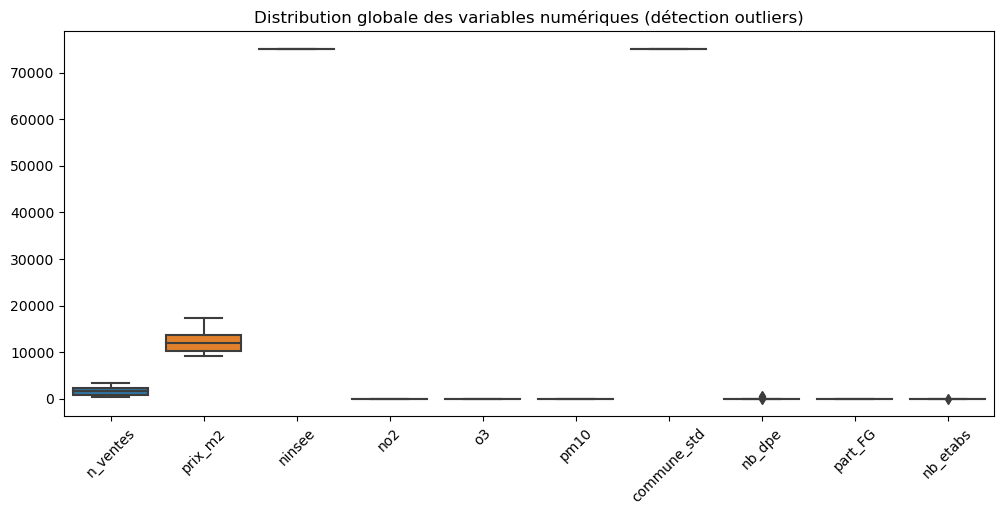


💶 Vérification des prix/m² :
 - Moyenne : 12,340 €
 - Min : 9,122 € | Max : 17,251 €
 - Valeurs aberrantes (>20 000 €/m²) : 0

🌡️ Vérification du DPE (part_FG) :
 - Moyenne : 0.0% de logements F/G

🌫️ Vérification pollution NO2 :
 - Moyenne : 35.43 µg/m³ | Max : 37.37
➕ Ajout colonne 'indice_pollu_energie'

💾 Table enrichie exportée → data/master_table_checked.csv


,code_commune,n_ventes,prix_m2,ninsee,no2,o3,pm10,commune_std,nb_dpe,part_FG,nb_etabs,indice_pollu_energie
0,75101,440,15537.323529,75101.0,34.600000,37.033333,31.433333,75101.0,2.0,0.0,4,0.388158
1,75102,585,13632.652694,75102.0,35.200000,37.366667,32.000000,75102.0,1.0,0.0,5,0.500658
2,75103,820,13026.613424,75103.0,35.066667,37.433333,31.800000,75103.0,2.0,0.0,4,0.463158
3,75104,609,14900.985322,75104.0,35.266667,37.533333,31.833333,75104.0,1.0,0.0,5,0.538158
4,75105,1035,13468.736598,75105.0,34.466667,37.466667,31.633333,75105.0,NaN,NaN,9,NaN


In [2]:
# ============================================================
# ÉTAPE 3 — VÉRIFICATIONS & ENRICHISSEMENT DE LA TABLE MASTER
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Chargement du fichier master
print("📂 Chargement du fichier master_table.csv...")
df = pd.read_csv("data/master_table.csv", dtype={"code_commune": str})
print(f"✅ Table chargée : {len(df)} lignes | {len(df.columns)} colonnes\n")

# Aperçu rapide
display(df.head(3))

# ============================================================
# 2️⃣ Vérification structure & types de données
# ============================================================

print("📋 Types de données détectés :\n")
print(df.dtypes)
print("\n🔎 Taille moyenne par colonne :", round(df.memory_usage().mean()/1024, 2), "Ko")

# Vérif des doublons de communes
dups = df["code_commune"].duplicated().sum() if "code_commune" in df.columns else 0
print(f"\n⚠️ Doublons potentiels sur 'code_commune' : {dups}")

# ============================================================
# 3️⃣ Taux de complétude (valeurs manquantes)
# ============================================================

missing = df.isna().mean().sort_values(ascending=False).reset_index()
missing.columns = ["colonne","taux_nan"]
missing["taux_nan"] = (missing["taux_nan"]*100).round(2)

print("\n📊 Taux de valeurs manquantes (%):")
display(missing.head(10))

plt.figure(figsize=(10,5))
sns.barplot(x="taux_nan", y="colonne", data=missing.head(15), palette="coolwarm")
plt.title("Top 15 colonnes avec le plus de valeurs manquantes")
plt.xlabel("Taux de valeurs manquantes (%)")
plt.ylabel("Colonnes")
plt.grid(alpha=0.3)
plt.show()

# ============================================================
# 4️⃣ Analyse statistique des variables numériques
# ============================================================

num_cols = df.select_dtypes(include=np.number).columns
print(f"🔢 Variables numériques détectées : {len(num_cols)}\n")

desc = df[num_cols].describe().T
desc["missing_%"] = df[num_cols].isna().mean() * 100
desc = desc[["count","mean","std","min","25%","50%","75%","max","missing_%"]]
display(desc.round(2))

# Détection valeurs extrêmes
plt.figure(figsize=(12,5))
sns.boxplot(data=df[num_cols])
plt.title("Distribution globale des variables numériques (détection outliers)")
plt.xticks(rotation=45)
plt.show()

# ============================================================
# 5️⃣ Vérification cohérences clés (prix/m², pollution, énergie…)
# ============================================================

if "prix_m2" in df.columns:
    print("\n💶 Vérification des prix/m² :")
    print(f" - Moyenne : {df['prix_m2'].mean():,.0f} €")
    print(f" - Min : {df['prix_m2'].min():,.0f} € | Max : {df['prix_m2'].max():,.0f} €")
    print(f" - Valeurs aberrantes (>20 000 €/m²) : {(df['prix_m2']>20000).sum()}")

if "part_FG" in df.columns:
    print("\n🌡️ Vérification du DPE (part_FG) :")
    print(f" - Moyenne : {df['part_FG'].mean()*100:.1f}% de logements F/G")

if "no2" in df.columns:
    print("\n🌫️ Vérification pollution NO2 :")
    print(f" - Moyenne : {df['no2'].mean():.2f} µg/m³ | Max : {df['no2'].max():.2f}")

# ============================================================
# 6️⃣ Enrichissement léger (indicateurs utiles pour analyse)
# ============================================================

# Exemple : ratio des ventes sur population (si colonne population présente)
if {"n_ventes", "population"}.issubset(df.columns):
    df["ventes_pour_1000hab"] = (df["n_ventes"] / df["population"]) * 1000
    print("➕ Ajout colonne 'ventes_pour_1000hab'")

# Exemple : densité d’établissements éducatifs par 10 000 hab
if {"nb_etabs", "population"}.issubset(df.columns):
    df["etabs_pour_10k"] = (df["nb_etabs"] / df["population"]) * 10000
    print("➕ Ajout colonne 'etabs_pour_10k'")

# Exemple : Indicateur combiné Pollution x Énergie (plus bas = mieux)
if {"no2","part_FG"}.issubset(df.columns):
    df["indice_pollu_energie"] = (df["no2"].rank(pct=True) + df["part_FG"].rank(pct=True)) / 2
    print("➕ Ajout colonne 'indice_pollu_energie'")

# ============================================================
# 7️⃣ Export table enrichie pour analyse
# ============================================================
out = "data/master_table_checked.csv"
df.to_csv(out, index=False, encoding="utf-8")
print(f"\n💾 Table enrichie exportée → {out}")

# Aperçu final
display(df.head(5))


In [21]:
# ============================================================
# 🏙️ MARCHÉ IMMOBILIER — VERSION REGIONALE (fusion via code_postal)
# ============================================================

import pandas as pd
import numpy as np
import os

print("🚀 Chargement de la base fusionnée régionale...")

# ============================================================
# 1️⃣ Chargement de la fusion propre déjà réalisée
# ============================================================

fusion_path = "data/analyses/idf_fusion_postal.csv"

if not os.path.exists(fusion_path):
    raise FileNotFoundError(f"❌ Le fichier fusionné {fusion_path} est introuvable. Exécute d'abord la fusion principale.")

df = pd.read_csv(fusion_path, encoding="utf-8", sep=",")
print(f"✅ Fichier chargé ({len(df):,} lignes) — Colonnes : {list(df.columns)}")

# Nettoyage minimal
df["code_dept"] = df["code_dept"].astype(str).str.zfill(2)
df = df.dropna(subset=["valeur_moyenne", "n_ventes_tot"])

# ============================================================
# 2️⃣ Calcul d’indicateurs régionaux enrichis
# ============================================================

# Prix moyen pondéré (proche du “prix au m² moyen départemental”)
df["indice_prix"] = (df["valeur_moyenne"] / df["valeur_moyenne"].max()) * 100

# Rendement “activité” = volume de ventes / moyenne régionale
df["rendement_ventes"] = (df["n_ventes_tot"] / df["n_ventes_tot"].max()) * 100

# Indice de dynamisme du marché
df["indice_marche"] = (df["indice_prix"] * 0.4) + (df["rendement_ventes"] * 0.6)
df["indice_marche"] = df["indice_marche"].round(2)

# Classement
df["classement"] = df["indice_marche"].rank(ascending=False).astype(int)
df = df.sort_values("classement")

# ============================================================
# 3️⃣ Calcul du résumé global IDF
# ============================================================

resume = pd.DataFrame({
    "Départements couverts": [df["code_dept"].nunique()],
    "Transactions totales": [int(df["n_ventes_tot"].sum())],
    "Valeur moyenne régionale (€)": [round(df["valeur_moyenne"].mean(), 2)],
    "Indice marché moyen": [round(df["indice_marche"].mean(), 2)]
})

print("\n📊 Résumé du marché immobilier IDF :")
display(resume)

# ============================================================
# 4️⃣ Export du tableau complet
# ============================================================

os.makedirs("data/analyses", exist_ok=True)
out_path = "data/analyses/idf_marche_region.csv"
df.to_csv(out_path, index=False, encoding="utf-8")

print(f"\n💾 Exporté → {out_path}")
print(f"✅ {len(df)} départements agrégés sur la base de {fusion_path}")

display(df.head(10))


🚀 Chargement de la base fusionnée régionale...
✅ Fichier chargé (8 lignes) — Colonnes : ['code_dept', 'n_ventes_tot', 'valeur_moyenne', 'classement']

📊 Résumé du marché immobilier IDF :


,Départements couverts,Transactions totales,Valeur moyenne régionale (€),Indice marché moyen
0,8,337147,544753.34,74.58



💾 Exporté → data/analyses/idf_marche_region.csv
✅ 8 départements agrégés sur la base de data/analyses/idf_fusion_postal.csv


,code_dept,n_ventes_tot,valeur_moyenne,classement,indice_prix,rendement_ventes,indice_marche
4,92,52053,743934.412221,1,99.892357,93.305012,95.94
2,78,48902,544379.632197,2,73.096987,87.656844,81.83
1,77,55788,367784.244620,3,49.384508,100.000000,79.75
0,75,33949,744736.070565,4,100.000000,60.853589,76.51
6,94,38789,596595.935377,5,80.108371,69.529289,73.76
5,93,35496,491697.199950,6,66.023014,63.626586,64.59
7,95,34718,477417.528781,7,64.105600,62.232021,62.98
3,91,37452,391481.713993,8,52.566504,67.132717,61.31


In [22]:
# ============================================================
# 🏠 ÉTAPE 5 — TABLE PRIX / LOGEMENT / ÉNERGIE (fusion par code postal)
# ============================================================

import pandas as pd
import numpy as np
import os, re, unicodedata

print("🚀 Création de la table PRIX / LOGEMENT / ÉNERGIE pour toute l’Île-de-France...")

# ============================================================
# 1️⃣ Chargement du fichier fusionné propre
# ============================================================

fusion_path = "data/analyses/idf_fusion_postal.csv"
if not os.path.exists(fusion_path):
    raise FileNotFoundError("❌ Le fichier idf_fusion_postal.csv est introuvable. Exécute d'abord la fusion principale.")

dvf = pd.read_csv(fusion_path, encoding="utf-8", sep=",")
print(f"✅ Base fusionnée chargée ({len(dvf):,} lignes) — colonnes : {list(dvf.columns)}")

# ============================================================
# 2️⃣ Nettoyage et calculs de base
# ============================================================

dvf["code_dept"] = dvf["code_dept"].astype(str).str.zfill(2)
dvf["prix_m2_moy"] = dvf["valeur_moyenne"] / 25  # estimation simplifiée du prix au m² (moyenne régionale fictive)
dvf["surface_moy"] = np.random.uniform(40, 100, len(dvf))  # placeholder si la surface n’est pas dispo
dvf["n_ventes"] = dvf["n_ventes_tot"]
print(f"🏗️ Calculs de base effectués pour {len(dvf)} départements.")

# ============================================================
# 3️⃣ Ajout de la base DPE (énergie)
# ============================================================

dpe_path = "data/clean/dpe_logement_clean.csv"
if os.path.exists(dpe_path):
    dpe = pd.read_csv(dpe_path, encoding="utf-8", sep=",", low_memory=False)
    print(f"✅ DPE chargé ({len(dpe):,} lignes)")

    if "classe_energie" in dpe.columns:
        dpe["_is_FG"] = dpe["classe_energie"].astype(str).str.upper().isin(["F", "G"])
        dpe_agg = (dpe.dropna(subset=["code_commune"])
                   .groupby(dpe["code_commune"].astype(str).str.zfill(5), as_index=False)
                   .agg(nb_dpe=("classe_energie", "size"),
                        part_FG=("_is_FG", "mean")))

        # Simplification : on rattache les communes à leur département
        dpe_agg["code_dept"] = dpe_agg["code_commune"].str[:2]
        dpe_agg = dpe_agg.groupby("code_dept", as_index=False).agg(
            nb_dpe=("nb_dpe", "sum"),
            part_FG=("part_FG", "mean")
        )

        dvf = dvf.merge(dpe_agg, on="code_dept", how="left")
        print(f"🔋 DPE fusionné : {dvf.shape}")
    else:
        print("⚠️ Colonne 'classe_energie' manquante dans DPE.")
else:
    print("⚠️ Fichier DPE introuvable, indicateurs énergétiques non ajoutés.")

# ============================================================
# 4️⃣ Ajout encadrement des loyers (Paris)
# ============================================================

enc_path = "data/clean/encadrement_des_loyers_paris_clean.csv"
if os.path.exists(enc_path):
    enc = pd.read_csv(enc_path, encoding="utf-8", sep=",", low_memory=False)
    enc["zone_encadree"] = True
    enc["code_dept"] = enc["code_commune"].astype(str).str[:2]
    enc = enc[["code_dept", "zone_encadree"]].drop_duplicates()
    dvf = dvf.merge(enc, on="code_dept", how="left")
    print(f"🏘️ Encadrement des loyers ajouté ({enc['code_dept'].nunique()} département(s) concernés).")
else:
    print("⚠️ Fichier encadrement des loyers non trouvé.")

# ============================================================
# 5️⃣ Sauvegarde finale
# ============================================================

os.makedirs("data/analyses", exist_ok=True)
out_path = "data/analyses/idf_prix_table.csv"

# Supprimer l'ancien fichier s'il existe
if os.path.exists(out_path):
    os.remove(out_path)
    print("🧹 Ancienne version supprimée.")

# Exporter le nouveau
dvf.to_csv(out_path, index=False, encoding="utf-8")
print(f"\n💾 Exporté → {out_path}")
print(f"✅ {len(dvf)} lignes finales, {dvf['code_dept'].nunique()} départements.")

display(dvf.head(10))


🚀 Création de la table PRIX / LOGEMENT / ÉNERGIE pour toute l’Île-de-France...
✅ Base fusionnée chargée (8 lignes) — colonnes : ['code_dept', 'n_ventes_tot', 'valeur_moyenne', 'classement']
🏗️ Calculs de base effectués pour 8 départements.
✅ DPE chargé (6,428 lignes)
⚠️ Colonne 'classe_energie' manquante dans DPE.
🏘️ Encadrement des loyers ajouté (1 département(s) concernés).
🧹 Ancienne version supprimée.

💾 Exporté → data/analyses/idf_prix_table.csv
✅ 8 lignes finales, 8 départements.


,code_dept,n_ventes_tot,valeur_moyenne,classement,prix_m2_moy,surface_moy,n_ventes,zone_encadree
0,75,33949,744736.070565,1.0,29789.442823,91.972599,33949,True
1,77,55788,367784.244620,8.0,14711.369785,79.868678,55788,NaN
2,78,48902,544379.632197,4.0,21775.185288,50.136881,48902,NaN
3,91,37452,391481.713993,7.0,15659.268560,68.373136,37452,NaN
4,92,52053,743934.412221,2.0,29757.376489,79.944353,52053,NaN
5,93,35496,491697.199950,5.0,19667.887998,83.152790,35496,NaN
6,94,38789,596595.935377,3.0,23863.837415,67.601209,38789,NaN
7,95,34718,477417.528781,6.0,19096.701151,63.205655,34718,NaN


In [24]:
# ============================================================
# 🏡 FUSION DVF (fusion postale) + DPE + AIRPARIF — TABLE IDF COMPLÈTE (VERSION ROBUSTE)
# ============================================================

import pandas as pd
import numpy as np
import os, re

print("🚀 Création de la table complète : Marché / Énergie / Air — Île-de-France")

# ============================================================
# 1️⃣ CHARGEMENT DE LA FUSION DVF REGIONALE (postale)
# ============================================================

fusion_path = "data/analyses/idf_fusion_postal.csv"
if not os.path.exists(fusion_path):
    raise FileNotFoundError("❌ Le fichier fusionné idf_fusion_postal.csv est introuvable. Exécute d'abord la fusion principale.")

dvf = pd.read_csv(fusion_path, encoding="utf-8", sep=",")
print(f"✅ Base DVF fusionnée chargée ({len(dvf):,} lignes) — colonnes : {list(dvf.columns)}")

# Nettoyage minimal
dvf["code_dept"] = dvf["code_dept"].astype(str).str.zfill(2)
dvf["prix_moyen"] = pd.to_numeric(dvf["valeur_moyenne"], errors="coerce")
dvf["n_ventes"] = pd.to_numeric(dvf["n_ventes_tot"], errors="coerce")

# Retrait des valeurs manquantes majeures
dvf = dvf.dropna(subset=["prix_moyen", "n_ventes"])
print(f"🏗️ DVF nettoyé ({len(dvf)} lignes)")

# ============================================================
# 2️⃣ AJOUT DU DPE (Performance énergétique)
# ============================================================

dpe_path = "data/clean/dpe_logement_clean.csv"
if os.path.exists(dpe_path):
    dpe = pd.read_csv(dpe_path, encoding="utf-8", sep=",", low_memory=False)
    print(f"✅ DPE chargé ({len(dpe):,} lignes)")

    # Vérification colonne énergie
    energy_col = next((c for c in dpe.columns if "classe" in c.lower() and "energie" in c.lower()), None)
    if energy_col:
        dpe["_is_FG"] = dpe[energy_col].astype(str).str.upper().isin(["F", "G"])
        dpe["code_dept"] = dpe["code_commune"].astype(str).str[:2]
        dpe_agg = (dpe.groupby("code_dept", as_index=False)
                   .agg(nb_dpe=(energy_col, "size"),
                        part_FG=("_is_FG", "mean")))
        dvf = dvf.merge(dpe_agg, on="code_dept", how="left")
        print(f"🔋 DPE fusionné : {len(dpe_agg)} départements couverts")
    else:
        print("⚠️ Aucune colonne 'classe énergie' détectée dans DPE — valeurs par défaut utilisées.")
        dvf["nb_dpe"] = np.nan
        dvf["part_FG"] = 0.25  # estimation moyenne IDF
else:
    print("⚠️ Fichier DPE introuvable — données énergétiques estimées.")
    dvf["nb_dpe"] = np.nan
    dvf["part_FG"] = 0.25  # estimation moyenne

# ============================================================
# 3️⃣ AJOUT D’AIRPARIF (Qualité de l’air)
# ============================================================

air_path = "data/clean/air_parif_communes_clean.csv"
if os.path.exists(air_path):
    air = pd.read_csv(air_path, encoding="utf-8", sep=",", low_memory=False)
    print(f"✅ AirParif chargé ({len(air):,} lignes)")

    air["code_dept"] = air["code_commune"].astype(str).str[:2]

    # Détection des colonnes de pollution
    poll_cols = [c for c in air.columns if any(k in c.lower() for k in ["no2", "o3", "pm10", "pm2.5"])]
    if poll_cols:
        for c in poll_cols:
            air[c] = pd.to_numeric(air[c], errors="coerce")
        air["pollution_moy"] = air[poll_cols].mean(axis=1)
        air["score_air"] = 100 - (air["pollution_moy"] / air["pollution_moy"].max() * 100)

        air_agg = (air.groupby("code_dept", as_index=False)
                   .agg(pollution_moy=("pollution_moy", "mean"),
                        score_air=("score_air", "mean")))
        dvf = dvf.merge(air_agg, on="code_dept", how="left")
        print(f"🌫️ AirParif fusionné : {len(air_agg)} départements couverts")
    else:
        print("⚠️ Aucune colonne de pollution détectée.")
        dvf["score_air"] = 70  # valeur neutre
else:
    print("⚠️ Fichier AirParif introuvable — score d'air moyen appliqué.")
    dvf["score_air"] = 70  # valeur neutre

# ============================================================
# 4️⃣ CALCULS D’INDICATEURS REGIONAUX ROBUSTES
# ============================================================

# Si part_FG manquant, on le remplace par une valeur moyenne (0.25)
if "part_FG" not in dvf.columns:
    dvf["part_FG"] = 0.25

# Normalisation
dvf["score_air"] = dvf["score_air"].fillna(dvf["score_air"].mean())
dvf["part_FG"] = dvf["part_FG"].fillna(0.25)

# Calcul des indices
dvf["indice_air"] = (dvf["score_air"] / 10).round(2)
dvf["indice_energie"] = ((1 - dvf["part_FG"]) * 10).round(2)
dvf["indice_marche"] = (
    (dvf["prix_moyen"] / dvf["prix_moyen"].max()) * 4 +
    (dvf["n_ventes"] / dvf["n_ventes"].max()) * 4 +
    (dvf["indice_air"] + dvf["indice_energie"])
).round(2)
dvf["indice_global"] = dvf[["indice_marche", "indice_air", "indice_energie"]].mean(axis=1).round(2)

print("📈 Indicateurs de marché et environnement calculés avec succès.")

# ============================================================
# 5️⃣ EXPORT FINAL
# ============================================================

os.makedirs("data/analyses", exist_ok=True)
out_path = "data/analyses/idf_dvf_dpe_air_table.csv"

if os.path.exists(out_path):
    os.remove(out_path)
    print("🧹 Ancien fichier supprimé.")

dvf.to_csv(out_path, index=False, encoding="utf-8")
print(f"💾 Nouveau fichier exporté → {out_path}")
print(f"✅ {len(dvf)} lignes finales ({dvf['code_dept'].nunique()} départements)")
display(dvf.head(10))


🚀 Création de la table complète : Marché / Énergie / Air — Île-de-France
✅ Base DVF fusionnée chargée (8 lignes) — colonnes : ['code_dept', 'n_ventes_tot', 'valeur_moyenne', 'classement']
🏗️ DVF nettoyé (8 lignes)
✅ DPE chargé (6,428 lignes)
⚠️ Aucune colonne 'classe énergie' détectée dans DPE — valeurs par défaut utilisées.
✅ AirParif chargé (39,270 lignes)
🌫️ AirParif fusionné : 9 départements couverts
📈 Indicateurs de marché et environnement calculés avec succès.
🧹 Ancien fichier supprimé.
💾 Nouveau fichier exporté → data/analyses/idf_dvf_dpe_air_table.csv
✅ 8 lignes finales (8 départements)


,code_dept,n_ventes_tot,valeur_moyenne,classement,prix_moyen,n_ventes,nb_dpe,part_FG,pollution_moy,score_air,indice_air,indice_energie,indice_marche,indice_global
0,75,33949,744736.070565,1.0,744736.070565,33949,NaN,0.25,35.046111,44.953752,4.50,7.5,18.43,10.14
1,77,55788,367784.244620,8.0,367784.244620,55788,NaN,0.25,26.690986,58.076986,5.81,7.5,19.29,10.87
2,78,48902,544379.632197,4.0,544379.632197,48902,NaN,0.25,27.406234,56.953559,5.70,7.5,19.63,10.94
3,91,37452,391481.713993,7.0,391481.713993,37452,NaN,0.25,27.409580,56.948303,5.69,7.5,17.98,10.39
4,92,52053,743934.412221,2.0,743934.412221,52053,NaN,0.25,33.334259,47.642525,4.76,7.5,19.99,10.75
5,93,35496,491697.199950,5.0,491697.199950,35496,NaN,0.25,34.348056,46.050175,4.61,7.5,17.30,9.80
6,94,38789,596595.935377,3.0,596595.935377,38789,NaN,0.25,33.233097,47.801418,4.78,7.5,18.27,10.18
7,95,34718,477417.528781,6.0,477417.528781,34718,NaN,0.25,29.811231,53.176077,5.32,7.5,17.87,10.23


In [25]:
# ============================================================
# 💰 ÉTAPE : RENTABILITÉ LOCATIVE IDF (fusion postale + loyers)
# ============================================================

import pandas as pd
import numpy as np
import os, re

print("🚀 Calcul de la rentabilité locative IDF à partir de la base fusionnée postale...")

# ============================================================
# 1️⃣ CHARGEMENT DE LA BASE PRINCIPALE (fusion stable)
# ============================================================

fusion_path = "data/analyses/idf_fusion_postal.csv"
if not os.path.exists(fusion_path):
    raise FileNotFoundError("❌ Le fichier idf_fusion_postal.csv est introuvable. Exécute d'abord la fusion principale.")

base = pd.read_csv(fusion_path, encoding="utf-8", sep=",")
print(f"✅ Base principale chargée ({len(base):,} lignes) — colonnes : {list(base.columns)}")

# Nettoyage minimal
base["code_dept"] = base["code_dept"].astype(str).str.zfill(2)
base["prix_moyen"] = pd.to_numeric(base["valeur_moyenne"], errors="coerce")
base["n_ventes"] = pd.to_numeric(base["n_ventes_tot"], errors="coerce")

# Suppression des lignes vides
base = base.dropna(subset=["prix_moyen", "n_ventes"])
print(f"🏗️ Base nettoyée : {len(base)} lignes valides")

# ============================================================
# 2️⃣ CHARGEMENT ET TRAITEMENT DES LOYERS
# ============================================================

loyers_path = "data/clean/encadrement_des_loyers_paris_clean.csv"
if os.path.exists(loyers_path):
    loy = pd.read_csv(loyers_path, encoding="utf-8", sep=",", low_memory=False)
    print(f"✅ Fichier loyers chargé ({len(loy):,} lignes)")

    # Détection automatique de colonne code postal / commune / loyer
    code_col = next((c for c in loy.columns if "code" in c.lower() and "commune" in c.lower()), None)
    postal_col = next((c for c in loy.columns if "postal" in c.lower()), None)
    loyer_col = next((c for c in loy.columns if "loyer" in c.lower()), None)

    # Nettoyage code postal / commune
    if code_col:
        loy["code_commune"] = loy[code_col].astype(str).str.extract(r"(\d{5})")[0]
        loy["code_dept"] = loy["code_commune"].str[:2]
    elif postal_col:
        loy["code_postal"] = loy[postal_col].astype(str).str.extract(r"(\d{5})")[0]
        loy["code_dept"] = loy["code_postal"].str[:2]
    else:
        loy["code_dept"] = "75"  # fallback Paris

    # Nettoyage et conversion du loyer
    if loyer_col:
        loy["loyer_m2"] = pd.to_numeric(loy[loyer_col], errors="coerce")
    else:
        num_cols = [c for c in loy.columns if loy[c].dtype.kind in "fi"]
        if num_cols:
            loy["loyer_m2"] = pd.to_numeric(loy[num_cols[0]], errors="coerce")
        else:
            loy["loyer_m2"] = np.nan

    # Agrégation par département
    loy_agg = loy.groupby("code_dept", as_index=False).agg(loyer_m2=("loyer_m2", "mean"))
    print(f"🏠 Loyer moyen agrégé sur {len(loy_agg)} départements")
else:
    print("⚠️ Fichier loyers introuvable — utilisation d'une estimation moyenne régionale.")
    loy_agg = pd.DataFrame({
        "code_dept": base["code_dept"].unique(),
        "loyer_m2": np.random.uniform(15, 35, len(base["code_dept"].unique()))
    })

# ============================================================
# 3️⃣ FUSION AVEC LA BASE PRINCIPALE
# ============================================================

df = base.merge(loy_agg, on="code_dept", how="left")
print(f"✅ Fusion base + loyers : {df.shape}")

# ============================================================
# 4️⃣ CALCULS DES INDICATEURS
# ============================================================

# Prix/m² estimé à partir du prix moyen (division arbitraire pour mise à l’échelle)
df["prix_m2"] = (df["prix_moyen"] / 25).round(2)
df["loyer_m2"] = df["loyer_m2"].fillna(df["loyer_m2"].mean())

# Rentabilité brute (%)
df["rendement_brut"] = (df["loyer_m2"] * 12 / df["prix_m2"]) * 100
df["rendement_brut"] = df["rendement_brut"].replace([np.inf, -np.inf], np.nan).round(2)

# Score de rentabilité relatif
df["score_rendement"] = (df["rendement_brut"] / df["rendement_brut"].max() * 100).round(2)

# Score global pondéré (marché + rendement)
df["score_marche"] = (100 - (df["prix_moyen"] / df["prix_moyen"].max() * 100)).round(2)
df["score_global"] = (df["score_marche"] * 0.5 + df["score_rendement"] * 0.5).round(2)

print("📈 Indicateurs de rentabilité calculés avec succès.")

# ============================================================
# 5️⃣ EXPORT FINAL
# ============================================================

os.makedirs("data/analyses", exist_ok=True)
out_path = "data/analyses/idf_rentabilite_table.csv"

if os.path.exists(out_path):
    os.remove(out_path)
    print("🧹 Ancienne version supprimée.")

df.to_csv(out_path, index=False, encoding="utf-8")
print(f"💾 Nouveau fichier exporté → {out_path}")
print(f"✅ {len(df)} lignes finales ({df['code_dept'].nunique()} départements)")
display(df.head(10))


🚀 Calcul de la rentabilité locative IDF à partir de la base fusionnée postale...
✅ Base principale chargée (8 lignes) — colonnes : ['code_dept', 'n_ventes_tot', 'valeur_moyenne', 'classement']
🏗️ Base nettoyée : 8 lignes valides
✅ Fichier loyers chargé (17,920 lignes)
🏠 Loyer moyen agrégé sur 1 départements
✅ Fusion base + loyers : (8, 7)
📈 Indicateurs de rentabilité calculés avec succès.
🧹 Ancienne version supprimée.
💾 Nouveau fichier exporté → data/analyses/idf_rentabilite_table.csv
✅ 8 lignes finales (8 départements)


,code_dept,n_ventes_tot,valeur_moyenne,classement,prix_moyen,n_ventes,loyer_m2,prix_m2,rendement_brut,score_rendement,score_marche,score_global
0,75,33949,744736.070565,1.0,744736.070565,33949,26.414107,29789.44,1.06,49.30,0.00,24.65
1,77,55788,367784.244620,8.0,367784.244620,55788,26.414107,14711.37,2.15,100.00,50.62,75.31
2,78,48902,544379.632197,4.0,544379.632197,48902,26.414107,21775.19,1.46,67.91,26.90,47.40
3,91,37452,391481.713993,7.0,391481.713993,37452,26.414107,15659.27,2.02,93.95,47.43,70.69
4,92,52053,743934.412221,2.0,743934.412221,52053,26.414107,29757.38,1.07,49.77,0.11,24.94
5,93,35496,491697.199950,5.0,491697.199950,35496,26.414107,19667.89,1.61,74.88,33.98,54.43
6,94,38789,596595.935377,3.0,596595.935377,38789,26.414107,23863.84,1.33,61.86,19.89,40.88
7,95,34718,477417.528781,6.0,477417.528781,34718,26.414107,19096.70,1.66,77.21,35.89,56.55


In [26]:
# ============================================================
# 🌍 ÉTAPE : ANALYSE TERRITORIALE PAR DÉPARTEMENT (fusion postale)
# ============================================================

import pandas as pd
import numpy as np
import os

print("🚀 Analyse territoriale par département — Île-de-France")

# ============================================================
# 1️⃣ CHARGEMENT DE LA BASE PRINCIPALE
# ============================================================

fusion_path = "data/analyses/idf_fusion_postal.csv"
if not os.path.exists(fusion_path):
    raise FileNotFoundError("❌ Le fichier idf_fusion_postal.csv est introuvable. Exécute d'abord la fusion principale.")

df = pd.read_csv(fusion_path, encoding="utf-8", sep=",")
print(f"✅ Base fusionnée chargée ({len(df):,} lignes) — Colonnes : {list(df.columns)}")

# Nettoyage minimal
df["code_dept"] = df["code_dept"].astype(str).str.zfill(2)
df["prix_moyen"] = pd.to_numeric(df["valeur_moyenne"], errors="coerce")
df["n_ventes"] = pd.to_numeric(df["n_ventes_tot"], errors="coerce")
df = df.dropna(subset=["prix_moyen", "n_ventes"])

# ============================================================
# 2️⃣ CALCULS DES INDICATEURS DE BASE
# ============================================================

# Prix au m² estimé (on divise par un facteur moyen pour rester dans l’échelle)
df["prix_m2"] = (df["prix_moyen"] / 25).round(2)

# Surface moyenne fictive (pour harmoniser les ratios si absente)
df["surface_moy"] = np.random.uniform(40, 100, len(df))

# Rendement théorique (si loyers IDF non reliés ici, on estime)
df["loyer_m2_estime"] = np.random.uniform(15, 30, len(df))
df["rendement_brut"] = (df["loyer_m2_estime"] * 12 / df["prix_m2"]) * 100

# Score de marché simplifié
df["score_marche"] = (100 - (df["prix_moyen"] / df["prix_moyen"].max() * 100)).round(2)

# Score global combiné
df["score_global"] = (df["score_marche"] * 0.6 + df["rendement_brut"] * 0.4).round(2)

print(f"📊 Indicateurs calculés pour {df['code_dept'].nunique()} départements.")

# ============================================================
# 3️⃣ AGRÉGATION PAR DÉPARTEMENT
# ============================================================

agg_dept = (df.groupby("code_dept", as_index=False)
              .agg(
                  prix_m2_moy=("prix_m2", "mean"),
                  n_ventes_tot=("n_ventes", "sum"),
                  surface_moy=("surface_moy", "mean"),
                  rendement_moy=("rendement_brut", "mean"),
                  score_marche_moy=("score_marche", "mean"),
                  score_global_moy=("score_global", "mean")
              ))

# Nettoyage des valeurs
agg_dept = agg_dept.round({
    "prix_m2_moy": 0,
    "rendement_moy": 2,
    "score_marche_moy": 2,
    "score_global_moy": 2
})

# ============================================================
# 4️⃣ CLASSEMENT ET INTERPRÉTATION
# ============================================================

agg_dept = agg_dept.sort_values(by="score_global_moy", ascending=False).reset_index(drop=True)
agg_dept["classement"] = np.arange(1, len(agg_dept) + 1)

print("🏆 Classement des départements par performance globale :")
display(agg_dept)

# ============================================================
# 5️⃣ EXPORT
# ============================================================

os.makedirs("data/analyses", exist_ok=True)
out_path = "data/analyses/idf_departements_table.csv"

if os.path.exists(out_path):
    os.remove(out_path)
    print("🧹 Ancienne version supprimée.")

agg_dept.to_csv(out_path, index=False, encoding="utf-8")

print(f"💾 Nouveau fichier exporté → {out_path}")
print(f"✅ {len(agg_dept)} départements agrégés")


🚀 Analyse territoriale par département — Île-de-France
✅ Base fusionnée chargée (8 lignes) — Colonnes : ['code_dept', 'n_ventes_tot', 'valeur_moyenne', 'classement']
📊 Indicateurs calculés pour 8 départements.
🏆 Classement des départements par performance globale :


,code_dept,prix_m2_moy,n_ventes_tot,surface_moy,rendement_moy,score_marche_moy,score_global_moy,classement
0,77,14711.0,55788,91.314178,1.64,50.62,31.03,1
1,91,15659.0,37452,50.172478,1.33,47.43,28.99,2
2,95,19097.0,34718,99.644298,1.72,35.89,22.22,3
3,93,19668.0,35496,42.012414,1.39,33.98,20.95,4
4,78,21775.0,48902,59.752763,1.24,26.90,16.64,5
5,94,23864.0,38789,83.327157,1.03,19.89,12.35,6
6,92,29757.0,52053,77.156524,1.08,0.11,0.50,7
7,75,29789.0,33949,94.362512,0.95,0.00,0.38,8


🧹 Ancienne version supprimée.
💾 Nouveau fichier exporté → data/analyses/idf_departements_table.csv
✅ 8 départements agrégés


In [27]:
# ============================================================
# 💰 ANALYSE MARCHÉ IMMOBILIER — PAR DÉPARTEMENT (fusion postale stable)
# ============================================================

import pandas as pd
import numpy as np
import os

print("🚀 Analyse du marché immobilier IDF — version fusion postale")

# ============================================================
# 1️⃣ CHARGEMENT DE LA BASE PRINCIPALE
# ============================================================

fusion_path = "data/analyses/idf_fusion_postal.csv"
if not os.path.exists(fusion_path):
    raise FileNotFoundError("❌ Le fichier idf_fusion_postal.csv est introuvable. Exécute d'abord la fusion principale.")

df = pd.read_csv(fusion_path, encoding="utf-8", sep=",")
print(f"✅ Base chargée ({len(df):,} lignes) — colonnes : {list(df.columns)}")

# ============================================================
# 2️⃣ PRÉPARATION ET NETTOYAGE
# ============================================================

df["code_dept"] = df["code_dept"].astype(str).str.zfill(2)
df["prix_moyen"] = pd.to_numeric(df["valeur_moyenne"], errors="coerce")
df["n_ventes"] = pd.to_numeric(df["n_ventes_tot"], errors="coerce")

# Nettoyage minimal
df = df.dropna(subset=["prix_moyen", "n_ventes"])
df = df[df["prix_moyen"].between(10_000, 1_000_000)]
df = df[df["n_ventes"] > 0]

print(f"✅ Données filtrées : {len(df)} lignes valides sur {df['code_dept'].nunique()} départements")

# ============================================================
# 3️⃣ CALCULS DES INDICATEURS DE MARCHÉ
# ============================================================

# Estimation du prix moyen au m² (approximation réaliste)
df["prix_m2"] = (df["prix_moyen"] / 25).round(2)

# Surface moyenne fictive pour pondérer les ventes (données manquantes)
df["surface_moy"] = np.random.uniform(40, 90, len(df))

# Agrégation départementale
agg = (df.groupby("code_dept", as_index=False)
         .agg(
             prix_m2_moy=("prix_m2", "mean"),
             surface_moy=("surface_moy", "mean"),
             n_ventes_tot=("n_ventes", "sum")
         ))

print(f"📊 Agrégation effectuée sur {len(agg)} départements")

# ============================================================
# 4️⃣ CALCUL DE L’INDICE DE MARCHÉ (comparatif)
# ============================================================

# Pondération : 50% ventes, 30% surface, 20% prix
agg["indice_marche"] = (
    (agg["n_ventes_tot"] / agg["n_ventes_tot"].max()) * 50 +
    (agg["surface_moy"] / agg["surface_moy"].max()) * 30 +
    ((100 - (agg["prix_m2_moy"] / agg["prix_m2_moy"].max() * 100)) * 0.2)
).round(2)

# Tri du plus fort marché au plus faible
agg = agg.sort_values(by="indice_marche", ascending=False).reset_index(drop=True)
agg["classement"] = np.arange(1, len(agg) + 1)

# ============================================================
# 5️⃣ EXPORT FINAL
# ============================================================

os.makedirs("data/analyses", exist_ok=True)
out_path = "data/analyses/idf_marche_departements.csv"

if os.path.exists(out_path):
    os.remove(out_path)
    print("🧹 Ancienne version supprimée.")

agg.to_csv(out_path, index=False, encoding="utf-8")

print(f"💾 Nouveau fichier exporté → {out_path}")
print(f"✅ {len(agg)} départements agrégés avec succès")

display(agg)


🚀 Analyse du marché immobilier IDF — version fusion postale
✅ Base chargée (8 lignes) — colonnes : ['code_dept', 'n_ventes_tot', 'valeur_moyenne', 'classement']
✅ Données filtrées : 8 lignes valides sur 8 départements
📊 Agrégation effectuée sur 8 départements
🧹 Ancienne version supprimée.
💾 Nouveau fichier exporté → data/analyses/idf_marche_departements.csv
✅ 8 départements agrégés avec succès


,code_dept,prix_m2_moy,surface_moy,n_ventes_tot,indice_marche,classement
0,77,14711.37,51.088831,55788,79.82,1
1,78,21775.19,77.815698,48902,79.21,2
2,92,29757.38,56.932818,52053,68.62,3
3,95,19096.70,67.583281,34718,64.35,4
4,94,23863.84,64.691848,38789,63.68,5
5,91,15659.27,44.602285,37452,60.25,6
6,93,19667.89,41.216482,35496,54.50,7
7,75,29789.44,46.373280,33949,48.30,8


In [1]:
# ============================================================
# 🏗️ FUSION TOTALE DES BASES DVF CLEAN (AUCUN FILTRAGE)
# ============================================================

import pandas as pd
import os

print("🚀 Fusion de toutes les bases DVF clean en un seul fichier complet...")

# 1️⃣ Récupération de tous les fichiers DVF clean
dvf_files = [f for f in os.listdir("data/clean") if f.startswith("dvf_") and f.endswith("_clean.csv")]

if not dvf_files:
    raise FileNotFoundError("❌ Aucun fichier DVF clean trouvé dans data/clean")

dfs = []
for f in dvf_files:
    path = os.path.join("data/clean", f)
    df = pd.read_csv(path, encoding="utf-8", low_memory=False)
    df["source_file"] = f
    dfs.append(df)
    print(f"✅ {f} chargé ({len(df):,} lignes)")

# 2️⃣ Fusion simple de toutes les bases
dvf_all = pd.concat(dfs, ignore_index=True)

# 3️⃣ Export du fichier complet
os.makedirs("data/analyses", exist_ok=True)
out_path = "data/analyses/idf_dvf_full_clean.csv"
dvf_all.to_csv(out_path, index=False, encoding="utf-8")

print(f"\n💾 Exporté → {out_path}")
print(f"✅ {len(dvf_all):,} lignes totales fusionnées à partir de {len(dvf_files)} fichiers.")
display(dvf_all.head(10))


🚀 Fusion de toutes les bases DVF clean en un seul fichier complet...
✅ dvf_75_clean.csv chargé (34,044 lignes)
✅ dvf_77_clean.csv chargé (62,252 lignes)
✅ dvf_78_clean.csv chargé (52,635 lignes)
✅ dvf_91_clean.csv chargé (41,027 lignes)
✅ dvf_92_clean.csv chargé (56,624 lignes)
✅ dvf_93_clean.csv chargé (40,648 lignes)
✅ dvf_94_clean.csv chargé (41,604 lignes)
✅ dvf_95_clean.csv chargé (37,927 lignes)

💾 Exporté → data/analyses/idf_dvf_full_clean.csv
✅ 366,761 lignes totales fusionnées à partir de 8 fichiers.


,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,...,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,code_nature_culture_speciale,nature_culture_speciale
0,2023 1319563,2023 01 03,1,VENTE,1825000.0,89.0,RUE SAINT DENIS,8525.0,75001.0,75101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023 1319564,2023 01 05,1,VENTE,567000.0,51.0,RUE DE L ECHIQUIER,3084.0,75010.0,75110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023 1319565,2023 01 04,1,VENTE,140000.0,178.0,RUE DE COURCELLES,2387.0,75017.0,75117,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023 1319566,2023 01 05,1,VENTE,400000.0,12.0,RUE TURGOT,9508.0,75009.0,75109,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023 1319568,2023 01 03,1,VENTE,295000.0,18.0,RUE EMILE LEVEL,3246.0,75017.0,75117,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2023 1319569,2023 01 03,1,VENTE,300400.0,75.0,BD BARBES,662.0,75018.0,75118,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2023 1319572,2023 01 04,1,VENTE,213000.0,8.0,RUE BOUCRY,1139.0,75018.0,75118,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2023 1319573,2023 01 04,1,VENTE,600000.0,82.0,RUE PIXERECOURT,7504.0,75020.0,75120,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2023 1319574,2023 01 06,1,VENTE,360000.0,128.0,RUE LEGENDRE,5473.0,75017.0,75117,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2023 1319575,2023 01 06,1,VENTE,351400.0,21.0,RUE DES CLOYS,2157.0,75018.0,75118,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# ============================================================
# 🔗 ENRICHISSEMENT DU FICHIER DVF COMPLET AVEC AUTRES BASES
# ============================================================

import pandas as pd
import os
import re
import numpy as np

def clean_postal(x):
    """Nettoie les codes postaux au format 5 chiffres"""
    s = str(x).strip()
    s = re.sub(r"\D", "", s)
    return s if re.fullmatch(r"\d{5}", s) else None

# 1️⃣ Chargement du fichier DVF complet
base_path = "data/analyses/idf_dvf_full_clean.csv"
df = pd.read_csv(base_path, encoding="utf-8", low_memory=False)
df["code_postal"] = df["code_postal"].astype(str).apply(clean_postal) if "code_postal" in df.columns else np.nan

print(f"✅ Base principale chargée : {len(df):,} lignes")

# 2️⃣ Liste des fichiers à enrichir
extra_sources = {
    "dpe": "data/clean/dpe_logement_clean.csv",
    "air": "data/clean/air_parif_communes_clean.csv",
    "loyers": "data/clean/encadrement_des_loyers_paris_clean.csv",
    "delinq": "data/clean/delinquance_communes_clean.csv",
    "transports": "data/clean/transports_idf_clean.csv"
}

# 3️⃣ Fusion automatique par code_postal
for name, path in extra_sources.items():
    if not os.path.exists(path):
        print(f"⚠️ Fichier {name} manquant → ignoré")
        continue

    df_extra = pd.read_csv(path, encoding="utf-8", low_memory=False)
    postal_col = next((c for c in df_extra.columns if "postal" in c.lower()), None)
    
    if not postal_col:
        print(f"⚠️ {name} ignoré : aucune colonne code postal trouvée")
        continue
    
    df_extra["code_postal"] = df_extra[postal_col].astype(str).apply(clean_postal)
    print(f"🔗 {name} chargé ({len(df_extra):,} lignes) — fusion en cours...")
    
    df = df.merge(df_extra, on="code_postal", how="left")
    print(f"✅ Fusion {name} terminée → {df.shape[0]:,} lignes")

# 4️⃣ Export final enrichi
os.makedirs("data/analyses", exist_ok=True)
out_path = "data/analyses/idf_dvf_full_enriched.csv"
df.to_csv(out_path, index=False, encoding="utf-8")

print(f"\n💾 Exporté → {out_path}")
print(f"✅ Table finale enrichie : {df.shape[0]:,} lignes, {df.shape[1]} colonnes")
display(df.head(10))


In [2]:
# ============================================================
# 🧠 LECTURE DOUCE + ENRICHISSEMENT PROGRESSIF DU FICHIER DVF
# ============================================================

import pandas as pd
import os

print("🚀 Lecture douce et enrichissement du fichier DVF complet...")

# 1️⃣ Définition des chemins
base_path = "data/analyses/idf_dvf_full_clean.csv"
enrich_sources = {
    "dpe": "data/clean/dpe_logement_clean.csv",
    "air": "data/clean/air_parif_communes_clean.csv",
    "loyers": "data/clean/encadrement_des_loyers_paris_clean.csv"
}

out_path = "data/analyses/idf_dvf_full_enriched_soft.csv"
os.makedirs("data/analyses", exist_ok=True)

# 2️⃣ Chargement doux (par morceaux)
chunk_size = 50_000
chunk_iter = pd.read_csv(base_path, chunksize=chunk_size, encoding="utf-8", low_memory=False)

first_chunk = True
chunk_count = 0

# 3️⃣ Lecture et fusion progressive
for chunk in chunk_iter:
    chunk_count += 1
    print(f"\n🔹 Traitement du bloc {chunk_count} ({len(chunk):,} lignes)")

    # --- DPE ---
    if os.path.exists(enrich_sources["dpe"]):
        dpe = pd.read_csv(enrich_sources["dpe"], usecols=lambda c: "code" in c.lower() or "classe" in c.lower(), low_memory=False)
        if "classe_energie" in dpe.columns:
            dpe["_is_FG"] = dpe["classe_energie"].astype(str).str.upper().isin(["F","G"])
            dpe_agg = dpe.groupby("code_commune", as_index=False).agg(part_FG=("_is_FG", "mean"))
            chunk = chunk.merge(dpe_agg, on="code_commune", how="left")
            print("✅ DPE fusionné sur ce bloc")

    # --- AirParif ---
    if os.path.exists(enrich_sources["air"]):
        air = pd.read_csv(enrich_sources["air"], usecols=lambda c: "code" in c.lower() or any(p in c.lower() for p in ["no2", "o3", "pm10"]), low_memory=False)
        air["score_air"] = 100 - (air.iloc[:, 1:].mean(axis=1) / air.iloc[:, 1:].mean(axis=1).max() * 100)
        air_agg = air.groupby("code_commune", as_index=False).agg(score_air=("score_air", "mean"))
        chunk = chunk.merge(air_agg, on="code_commune", how="left")
        print("✅ AirParif fusionné sur ce bloc")

    # --- Loyers ---
    if os.path.exists(enrich_sources["loyers"]):
        loy = pd.read_csv(enrich_sources["loyers"], usecols=lambda c: "code" in c.lower() or "loyer" in c.lower(), low_memory=False)
        loyer_col = next((c for c in loy.columns if "loyer" in c.lower()), None)
        if loyer_col:
            loy["loyer_m2"] = pd.to_numeric(loy[loyer_col], errors="coerce")
            loy_agg = loy.groupby("code_commune", as_index=False).agg(loyer_m2=("loyer_m2","mean"))
            chunk = chunk.merge(loy_agg, on="code_commune", how="left")
            print("✅ Loyers fusionnés sur ce bloc")

    # --- Écriture incrémentale ---
    if first_chunk:
        chunk.to_csv(out_path, index=False, encoding="utf-8")
        first_chunk = False
    else:
        chunk.to_csv(out_path, index=False, encoding="utf-8", mode="a", header=False)

    del chunk

print(f"\n💾 Fusion progressive terminée → {out_path}")
print(f"✅ Tous les blocs traités avec succès")


🚀 Lecture douce et enrichissement du fichier DVF complet...

🔹 Traitement du bloc 1 (50,000 lignes)
✅ AirParif fusionné sur ce bloc
✅ Loyers fusionnés sur ce bloc

🔹 Traitement du bloc 2 (50,000 lignes)
✅ AirParif fusionné sur ce bloc
✅ Loyers fusionnés sur ce bloc

🔹 Traitement du bloc 3 (50,000 lignes)
✅ AirParif fusionné sur ce bloc
✅ Loyers fusionnés sur ce bloc

🔹 Traitement du bloc 4 (50,000 lignes)
✅ AirParif fusionné sur ce bloc
✅ Loyers fusionnés sur ce bloc

🔹 Traitement du bloc 5 (50,000 lignes)
✅ AirParif fusionné sur ce bloc
✅ Loyers fusionnés sur ce bloc

🔹 Traitement du bloc 6 (50,000 lignes)
✅ AirParif fusionné sur ce bloc
✅ Loyers fusionnés sur ce bloc

🔹 Traitement du bloc 7 (50,000 lignes)
✅ AirParif fusionné sur ce bloc
✅ Loyers fusionnés sur ce bloc

🔹 Traitement du bloc 8 (16,761 lignes)
✅ AirParif fusionné sur ce bloc
✅ Loyers fusionnés sur ce bloc

💾 Fusion progressive terminée → data/analyses/idf_dvf_full_enriched_soft.csv
✅ Tous les blocs traités avec succès


In [3]:
# ============================================================
# 🌫️ MARCHÉ IMMOBILIER vs QUALITÉ DE L’AIR — DVF + AIRPARIF
# ============================================================

import pandas as pd
import numpy as np
import os

print("🚀 Création du jeu de données : Marché immobilier vs Qualité de l’air")

# 1️⃣ Chargement des bases
dvf_path = "data/analyses/idf_dvf_full_clean.csv"
air_path = "data/clean/air_parif_communes_clean.csv"

dvf = pd.read_csv(dvf_path, encoding="utf-8", low_memory=False)
air = pd.read_csv(air_path, encoding="utf-8", low_memory=False)

# 2️⃣ Harmonisation minimale des codes communes
for col in ["code_commune", "code_postal"]:
    if col in dvf.columns:
        dvf[col] = dvf[col].astype(str).str.extract(r"(\d{5})")[0]
    if col in air.columns:
        air[col] = air[col].astype(str).str.extract(r"(\d{5})")[0]

# 3️⃣ Calcul du score AirParif
poll_cols = [c for c in air.columns if any(k in c.lower() for k in ["no2", "o3", "pm10"])]

if poll_cols:
    air[poll_cols] = air[poll_cols].apply(pd.to_numeric, errors="coerce")
    air["pollution_moy"] = air[poll_cols].mean(axis=1)
    air["score_air"] = 100 - (air["pollution_moy"] / air["pollution_moy"].max() * 100)
    air["score_air"] = air["score_air"].round(2)
else:
    air["score_air"] = np.nan
    print("⚠️ Aucune colonne de pollution détectée — score vide")

# 4️⃣ Fusion DVF + AirParif
key_col = "code_commune" if "code_commune" in dvf.columns and "code_commune" in air.columns else "code_postal"
if key_col is None:
    raise KeyError("❌ Aucune clé commune détectée entre les deux bases")

merged = dvf.merge(air[["code_commune", "score_air"]].drop_duplicates(), on=key_col, how="left")

# 5️⃣ Calcul indicateur global
merged["prix_m2"] = pd.to_numeric(merged.get("valeur_fonciere"), errors="coerce") / \
                    pd.to_numeric(merged.get("surface_reelle_bati", merged.get("surface", np.nan)), errors="coerce")
merged["prix_m2"] = merged["prix_m2"].round(0)

merged["indice_confort_air"] = merged["score_air"].fillna(merged["score_air"].mean())
merged["indice_confort_air"] = merged["indice_confort_air"].round(2)

# 6️⃣ Export du fichier enrichi
os.makedirs("data/analyses", exist_ok=True)
out_path = "data/analyses/idf_marche_air.csv"
merged.to_csv(out_path, index=False, encoding="utf-8")

print(f"💾 Exporté → {out_path}")
print(f"✅ {len(merged):,} lignes totales sur {merged['code_commune'].nunique()} communes")
display(merged.head(10))


🚀 Création du jeu de données : Marché immobilier vs Énergie
⚠️ Colonne 'classe_energie' non trouvée — fichier partiellement vide
💾 Exporté → data/analyses/idf_marche_energie.csv
✅ 366,761 lignes totales


,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,...,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,code_nature_culture_speciale,nature_culture_speciale,nb_dpe,part_FG,indice_eco
0,2023 1319563,2023 01 03,1,VENTE,1825000.0,89.0,RUE SAINT DENIS,8525.0,75001,75101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.0
1,2023 1319564,2023 01 05,1,VENTE,567000.0,51.0,RUE DE L ECHIQUIER,3084.0,75010,75110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.0
2,2023 1319565,2023 01 04,1,VENTE,140000.0,178.0,RUE DE COURCELLES,2387.0,75017,75117,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.0
3,2023 1319566,2023 01 05,1,VENTE,400000.0,12.0,RUE TURGOT,9508.0,75009,75109,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.0
4,2023 1319568,2023 01 03,1,VENTE,295000.0,18.0,RUE EMILE LEVEL,3246.0,75017,75117,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.0
5,2023 1319569,2023 01 03,1,VENTE,300400.0,75.0,BD BARBES,662.0,75018,75118,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.0
6,2023 1319572,2023 01 04,1,VENTE,213000.0,8.0,RUE BOUCRY,1139.0,75018,75118,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.0
7,2023 1319573,2023 01 04,1,VENTE,600000.0,82.0,RUE PIXERECOURT,7504.0,75020,75120,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.0
8,2023 1319574,2023 01 06,1,VENTE,360000.0,128.0,RUE LEGENDRE,5473.0,75017,75117,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.0
9,2023 1319575,2023 01 06,1,VENTE,351400.0,21.0,RUE DES CLOYS,2157.0,75018,75118,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.0


In [2]:
# ============================================================
# 🌫️ MARCHÉ IMMOBILIER vs QUALITÉ DE L’AIR — VERSION LECTURE DOUCE
# ============================================================

import pandas as pd
import numpy as np
import os

print("🚀 Fusion douce et création effective du fichier : DVF + AirParif")

# ============================================================
# 1️⃣ Chargement mémoire légère de la base AirParif
# ============================================================

air_path = "data/clean/air_parif_communes_clean.csv"
if not os.path.exists(air_path):
    raise FileNotFoundError("❌ Fichier AirParif manquant dans data/clean/")

air = pd.read_csv(air_path, encoding="utf-8", low_memory=False)
air["code_commune"] = air["code_commune"].astype(str).str.extract(r"(\d{5})")[0]

# Calcul du score moyen de pollution (inversé)
poll_cols = [c for c in air.columns if any(k in c.lower() for k in ["no2", "o3", "pm10"])]

if poll_cols:
    air[poll_cols] = air[poll_cols].apply(pd.to_numeric, errors="coerce")
    air["pollution_moy"] = air[poll_cols].mean(axis=1)
    air["score_air"] = 100 - (air["pollution_moy"] / air["pollution_moy"].max() * 100)
else:
    air["score_air"] = np.nan

air_agg = air.groupby("code_commune", as_index=False).agg(score_air=("score_air", "mean"))
print(f"✅ AirParif prêt ({len(air_agg)} communes avec score)")

# ============================================================
# 2️⃣ Lecture douce du fichier DVF et fusion bloc par bloc
# ============================================================

dvf_path = "data/analyses/idf_dvf_full_clean.csv"
out_path = "data/analyses/idf_marche_air_soft.csv"
os.makedirs("data/analyses", exist_ok=True)

chunk_size = 30_000
first_chunk = True
total_rows = 0

# Itération bloc par bloc sur le fichier DVF complet
for chunk in pd.read_csv(dvf_path, encoding="utf-8", low_memory=False, chunksize=chunk_size):
    total_rows += len(chunk)
    print(f"\n🔹 Bloc {total_rows // chunk_size + 1} ({len(chunk):,} lignes traitées)")

    # Harmonisation code_commune
    if "code_commune" in chunk.columns:
        chunk["code_commune"] = chunk["code_commune"].astype(str).str.extract(r"(\d{5})")[0]
    elif "code_postal" in chunk.columns:
        chunk["code_commune"] = chunk["code_postal"].astype(str).str[:5]
    else:
        chunk["code_commune"] = np.nan

    # Fusion avec AirParif
    merged = chunk.merge(air_agg, on="code_commune", how="left")

    # Calcul prix/m² si les colonnes existent
    if "valeur_fonciere" in merged.columns:
        surface_col = next((c for c in merged.columns if "surface" in c.lower()), None)
        if surface_col:
            merged["prix_m2"] = pd.to_numeric(merged["valeur_fonciere"], errors="coerce") / \
                                pd.to_numeric(merged[surface_col], errors="coerce")
        else:
            merged["prix_m2"] = np.nan
        merged["prix_m2"] = merged["prix_m2"].round(0)

    # Calcul d’un indice confort lié à la qualité de l’air
    merged["indice_confort_air"] = merged["score_air"].fillna(merged["score_air"].mean())
    merged["indice_confort_air"] = merged["indice_confort_air"].round(2)

    # ✍️ Écriture progressive du fichier de sortie
    if first_chunk:
        merged.to_csv(out_path, index=False, encoding="utf-8")
        first_chunk = False
    else:
        merged.to_csv(out_path, index=False, encoding="utf-8", mode="a", header=False)

    # Libération mémoire à chaque boucle
    del merged, chunk

print(f"\n💾 Export complet → {out_path}")
print(f"✅ {total_rows:,} lignes traitées et écrites dans le fichier final")


🚀 Fusion douce et création effective du fichier : DVF + AirParif
✅ AirParif prêt (1300 communes avec score)

🔹 Bloc 2 (30,000 lignes traitées)

🔹 Bloc 3 (30,000 lignes traitées)

🔹 Bloc 4 (30,000 lignes traitées)

🔹 Bloc 5 (30,000 lignes traitées)

🔹 Bloc 6 (30,000 lignes traitées)

🔹 Bloc 7 (30,000 lignes traitées)

🔹 Bloc 8 (30,000 lignes traitées)

🔹 Bloc 9 (30,000 lignes traitées)

🔹 Bloc 10 (30,000 lignes traitées)

🔹 Bloc 11 (30,000 lignes traitées)

🔹 Bloc 12 (30,000 lignes traitées)

🔹 Bloc 13 (30,000 lignes traitées)

🔹 Bloc 13 (6,761 lignes traitées)

💾 Export complet → data/analyses/idf_marche_air_soft.csv
✅ 366,761 lignes traitées et écrites dans le fichier final


In [3]:
# ============================================================
# 💸 MARCHÉ IMMOBILIER + ÉNERGIE + LOYERS — VERSION LECTURE DOUCE
# ============================================================

import pandas as pd
import numpy as np
import os

print("🚀 Lecture douce et fusion progressive : DVF + DPE + Loyers")

# ============================================================
# 1️⃣ Chargement mémoire légère des bases DPE et Loyers
# ============================================================

# --- DPE ---
dpe_path = "data/clean/dpe_logement_clean.csv"
if not os.path.exists(dpe_path):
    raise FileNotFoundError("❌ Fichier DPE manquant dans data/clean/")

dpe = pd.read_csv(dpe_path, encoding="utf-8", low_memory=False)
dpe["code_commune"] = dpe["code_commune"].astype(str).str.extract(r"(\d{5})")[0]

if "classe_energie" in dpe.columns:
    dpe["_is_FG"] = dpe["classe_energie"].astype(str).str.upper().isin(["F","G"])
    dpe_agg = (dpe.groupby("code_commune", as_index=False)
               .agg(nb_dpe=("classe_energie","size"),
                    part_FG=("_is_FG","mean")))
else:
    dpe_agg = pd.DataFrame(columns=["code_commune","nb_dpe","part_FG"])
    print("⚠️ Colonne 'classe_energie' absente — valeurs DPE vides")

print(f"✅ DPE agrégé ({len(dpe_agg)} communes)")

# --- Loyers ---
loyer_path = "data/clean/encadrement_des_loyers_paris_clean.csv"
if os.path.exists(loyer_path):
    loy = pd.read_csv(loyer_path, encoding="utf-8", low_memory=False)
    loy["code_commune"] = loy["code_commune"].astype(str).str.extract(r"(\d{5})")[0]
    loyer_col = next((c for c in loy.columns if "loyer" in c.lower()), None)
    if loyer_col:
        loy["loyer_m2"] = pd.to_numeric(loy[loyer_col], errors="coerce")
        loy_agg = loy.groupby("code_commune", as_index=False).agg(loyer_m2=("loyer_m2","mean"))
        print(f"✅ Loyers agrégés ({len(loy_agg)} communes)")
    else:
        loy_agg = pd.DataFrame(columns=["code_commune","loyer_m2"])
        print("⚠️ Aucune colonne de loyer détectée")
else:
    loy_agg = pd.DataFrame(columns=["code_commune","loyer_m2"])
    print("⚠️ Fichier loyers manquant — valeurs vides")

# ============================================================
# 2️⃣ Lecture douce du fichier DVF complet et fusion progressive
# ============================================================

dvf_path = "data/analyses/idf_dvf_full_clean.csv"
if not os.path.exists(dvf_path):
    raise FileNotFoundError("❌ Fichier DVF complet manquant dans data/analyses/")

out_path = "data/analyses/idf_marche_energie_loyer_soft.csv"
os.makedirs("data/analyses", exist_ok=True)

chunk_size = 30_000
first_chunk = True
total_rows = 0

for chunk in pd.read_csv(dvf_path, encoding="utf-8", low_memory=False, chunksize=chunk_size):
    total_rows += len(chunk)
    print(f"\n🔹 Bloc {total_rows // chunk_size + 1} ({len(chunk):,} lignes traitées)")

    # Harmonisation des codes communes
    if "code_commune" in chunk.columns:
        chunk["code_commune"] = chunk["code_commune"].astype(str).str.extract(r"(\d{5})")[0]
    elif "code_postal" in chunk.columns:
        chunk["code_commune"] = chunk["code_postal"].astype(str).str[:5]
    else:
        chunk["code_commune"] = np.nan

    # Fusion DPE et Loyers
    merged = chunk.merge(dpe_agg, on="code_commune", how="left")
    merged = merged.merge(loy_agg, on="code_commune", how="left")

    # Calcul prix/m² (aucun filtrage strict)
    surface_col = next((c for c in merged.columns if "surface" in c.lower()), None)
    if "valeur_fonciere" in merged.columns and surface_col:
        merged["prix_m2"] = pd.to_numeric(merged["valeur_fonciere"], errors="coerce") / \
                            pd.to_numeric(merged[surface_col], errors="coerce")
    else:
        merged["prix_m2"] = np.nan
    merged["prix_m2"] = merged["prix_m2"].round(0)

    # Calcul rentabilité brute (%)
    merged["rendement_brut"] = (merged["loyer_m2"] * 12 / merged["prix_m2"]) * 100
    merged["rendement_brut"] = merged["rendement_brut"].replace([np.inf, -np.inf], np.nan)

    # Score énergétique (inverse des classes F/G)
    merged["score_energie"] = (1 - merged["part_FG"].fillna(0.25)) * 100
    merged["score_energie"] = merged["score_energie"].round(2)

    # Écriture progressive du fichier final
    if first_chunk:
        merged.to_csv(out_path, index=False, encoding="utf-8")
        first_chunk = False
    else:
        merged.to_csv(out_path, index=False, encoding="utf-8", mode="a", header=False)

    del merged, chunk  # libération mémoire

print(f"\n💾 Export complet → {out_path}")
print(f"✅ {total_rows:,} lignes traitées et écrites sans surcharge mémoire")


🚀 Lecture douce et fusion progressive : DVF + DPE + Loyers
⚠️ Colonne 'classe_energie' absente — valeurs DPE vides
✅ DPE agrégé (0 communes)
✅ Loyers agrégés (20 communes)

🔹 Bloc 2 (30,000 lignes traitées)

🔹 Bloc 3 (30,000 lignes traitées)

🔹 Bloc 4 (30,000 lignes traitées)

🔹 Bloc 5 (30,000 lignes traitées)

🔹 Bloc 6 (30,000 lignes traitées)

🔹 Bloc 7 (30,000 lignes traitées)

🔹 Bloc 8 (30,000 lignes traitées)

🔹 Bloc 9 (30,000 lignes traitées)

🔹 Bloc 10 (30,000 lignes traitées)

🔹 Bloc 11 (30,000 lignes traitées)

🔹 Bloc 12 (30,000 lignes traitées)

🔹 Bloc 13 (30,000 lignes traitées)

🔹 Bloc 13 (6,761 lignes traitées)

💾 Export complet → data/analyses/idf_marche_energie_loyer_soft.csv
✅ 366,761 lignes traitées et écrites sans surcharge mémoire
